Task 3: Data Assimilation with linear compression (30%)

This third task is assimilating satellite data (Ferguson_fire_obs) into the model data 
(Ferguson_fire_background)for real-time adjustment.

link to trained pca model:

 https://imperiallondon-my.sharepoint.com/:f:/g/personal/iyc23_ic_ac_uk/EnN4Pw8VSfxMpZMLgjK0J2QBEJlF1ahfsMtk8E1EMaoRJg?e=NZZBV6

filename:<brk>
"incremental_150pca_model.pkl"

In [1]:
import numpy as np
import joblib
import time
import matplotlib.pyplot as plt

In [2]:
model_data =np.load('Ferguson_fire_background/Ferguson_fire_background.npy')
obs_data =np.load('Ferguson_fire_obs.npy')

In [3]:
model_1D =np.reshape(model_data, (np.shape(model_data)[0],np.shape(model_data)[1]*np.shape(model_data)[2]))
obs_1D=np.reshape(obs_data, (np.shape(obs_data)[0],np.shape(obs_data)[1]*np.shape(obs_data)[2]))

In [4]:
transformer_loaded = joblib.load('incremental_150pca_model.pkl')

In [5]:
transformer_loaded
s3 =time.time()
compressed_model_data = transformer_loaded.transform(model_1D)
compressed_obs_data = transformer_loaded.transform(obs_1D)
e3 =time.time()
print('the time', e3-s3)


the time 0.03298187255859375


In [6]:
nNodes =5
I = np.identity(nNodes)
R = np.cov(compressed_model_data.T)*10
H = np.eye(150,150)
B = np.cov(
    compressed_model_data.T
)*0.1  

the observational data seems less reliable than the model data therefor, I have made the R matrix learger than the B matrix, as it means there will be less importance put on it during the Kalman Filter.

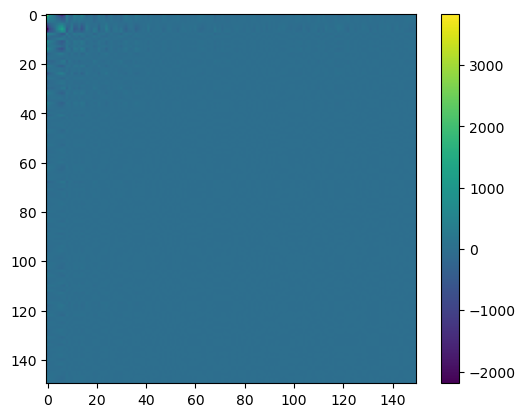

In [7]:
plt.imshow(R, cmap='viridis')  # You can choose any colormap you prefer
plt.colorbar()  # Add a colorbar for reference
plt.show()

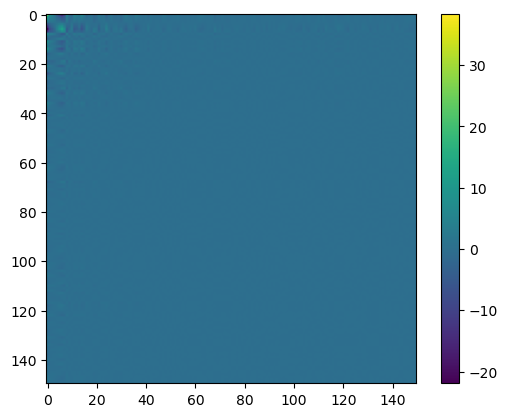

In [8]:
plt.imshow(B, cmap='viridis')  # You can choose any colormap you prefer
plt.colorbar()  # Add a colorbar for reference
plt.show()

The Matrices shows low correlation in the errors, there seems to be larger error variation in the R matrix which suggests it is less reliable.

2. Test the assimilation model and submit both code and results including: 

• MSE in the reduced space and execution time. 10%

• MSE in the physical space (after decompression) and execution time. 10%

In [9]:
from numpy.linalg import inv


def covariance_matrix(X):
    means = np.array([np.mean(X, axis=1)]).transpose()
    dev_matrix = X - means
    res = np.dot(dev_matrix, dev_matrix.transpose()) / (X.shape[1] - 1)
    return res


def update_prediction(x, K, H, y):
    res = x + np.dot(K, (y - np.dot(H, x)))
    return res


def KalmanGain(B, H, R):
    tempInv = inv(R + np.dot(H, np.dot(B, H.transpose())))
    res = np.dot(B, np.dot(H.transpose(), tempInv))
    return res


def mse(y_obs, y_pred):
    return np.square(np.subtract(y_obs, y_pred)).mean()

In [10]:
print("Start Assimilation")
start = time.time()
K=KalmanGain(B,H,R)
update_data_list =[]
for i in range(len(compressed_model_data)):
    update_data =update_prediction(compressed_model_data[i],K,H,compressed_obs_data[i])
    update_data_list.append(update_data)
update_data_arr =np.array(update_data_list)
end = time.time()
mse_compressed =mse(compressed_model_data,update_data_arr)
s1 =time.time()
decomp =transformer_loaded.inverse_transform(update_data_arr)
e1 =time.time()
mse_decom =mse(model_1D,decomp)
print("compressed space MSE ",mse_compressed)
print("phyisical space MSE ",mse_decom)
print(end-start)
print('decompression time', e1-s1)

Start Assimilation
compressed space MSE  6.996700212890538
phyisical space MSE  0.028825404503910745
0.07156658172607422
decompression time 0.010962724685668945


In [11]:
print('mse_sensor', mse(compressed_obs_data,update_data_arr))
print('mse sense in physical space', mse(obs_1D, decomp))

mse_sensor 14.631157583616961
mse sense in physical space 0.06907846051604585


The results:<br>

compressed space MSE  6.996700212890538<br>
phyisical space MSE  0.028825404503910745<br>
data assimialation time :0.07262420654296875<br>
decompression time 0.016338586807250977
